# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

from matplotlib_venn import venn2
from scipy.stats import mannwhitneyu
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Brain proteome (HPA)

In [3]:
def get_uniprot(string):
    try:
        _, uniprot, _ = string.split("|")
    except:
        _, uniprot, _ = string.split("_", maxsplit=2)  
    return uniprot

def keep_first_uniprot(string):
    if "," in string:
        uniprots = string.split(",")
        uniprot1 = uniprots[0]
    else:
        uniprot1 = string
    
    return uniprot1

def get_brain_expression(string):
    # check if expression for multiple tissues is provided
    if ";" in string:
        tissues = string.split(";")
        for t in tissues:
            # keep only information on brain expression
            if "brain" in t:
                brain_string = t 
    else:
        brain_string = string
    
    # extract expression value from string
    _, exp = brain_string.split(" ")
    exp = float(exp)

    return exp

def get_brain_expression_detected(string):
    
    # return None is no information is available
    if type(string) != str:
        return None

    # check if expression for multiple tissues is provided
    tissues = string.split(";")
    for t in tissues:
        # keep only information on brain expression
        if "brain" in t:
            brain_string = t 
        else:
            return None
    
    # extract expression value from string
    _, exp = brain_string.split(" ")
    exp = float(exp)

    return exp

In [4]:
brain_detected = pd.read_csv(data_path + "Brain/Brain_detected.csv")

In [5]:
brain_elevated = pd.read_csv(data_path + "Brain/Brain_elevated.csv")

## Feature data sets

In [6]:
# all human proteins
df = pd.read_csv(data_path + "/Features/df_features.csv")
# all proteins detected in brain
df_detected = pd.read_csv(data_path + "/Features/df_features_brain_detected.csv")
# all proteins detected in brain that were not part of the training and testing (i.e. brain elevated) set
df_val = pd.read_csv(data_path + "/Features/df_features_brain_detected_val.csv")
# all proteins elevated in brain
df_elevated = pd.read_csv(data_path + "/Features/df_features_brain_elevated.csv")

In [7]:
df_Higginbotham2020 = pd.read_csv(data_path + "/Features/df_features_Higginbotham2020.csv")
# df_Higginbotham2020.drop(["Peroxisome", "Lysosome/Vacuole", "Plastid"], axis=1, inplace=True)

## CSF

In [8]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

In [9]:
def get_uniprot_alt(string):
    _, uniprot = string.split("|")
    
    if "-" in uniprot:
        uniprot, _ = uniprot.split("-")

    return uniprot

In [10]:
# import protein lists
Higginbotham2020_brain = pd.read_csv(data_path + "/Biomarker_discovery/Higginbotham2020_protein_list_brain.txt", header=None, 
    names=["Uniprot"])
Higginbotham2020_CSF = pd.read_csv(data_path + "/Biomarker_discovery/Higginbotham2020_protein_list_CSF.txt", 
    header=None, names=["Uniprot"])

In [11]:
# retrieve (parent) Uniprot
Higginbotham2020_brain["Uniprot"] = Higginbotham2020_brain["Uniprot"].apply(get_uniprot_alt)
Higginbotham2020_CSF["Uniprot"] = Higginbotham2020_CSF["Uniprot"].apply(get_uniprot_alt)

## Model and scaler

In [12]:
with open(os.getcwd() + "/Models/LogisticClassifier_L2.pkl", "rb") as f:  
    lr_l2 = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_2plus.pkl", "rb") as f:  
    lr_l2_2plus = pickle.load(f)
with open(os.getcwd() + "/Models/LogisticClassifier_L2_3plus.pkl", "rb") as f:  
    lr_l2_3plus = pickle.load(f)

In [13]:
# with open(os.getcwd() + "/Models/LogisticClassifier_L1.pkl", "rb") as f:  
#     lr_l2 = pickle.load(f)
# with open(os.getcwd() + "/Models/LogisticClassifier_L1_2plus.pkl", "rb") as f:  
#     lr_l2_2plus = pickle.load(f)
# with open(os.getcwd() + "/Models/LogisticClassifier_L1_3plus.pkl", "rb") as f:  
#     lr_l2_3plus = pickle.load(f)

In [14]:
with open(os.getcwd() + "/Models/Standard_scaler.pkl", "rb") as f:  
    scaler = pickle.load(f)

# Prediction

In [15]:
# define continuous variables
cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
        'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Polar', 'Neutral', 'Hydrophobic', 'Volume_small', 
        'Volume_medium', 'Volume_large', 'Polarity_low', 'Polarity_medium', 'Polarity_large', 'Polarizability_low', 
        'Polarizability_medium', 'Polarizability_large', 'Charge_positive', 'Charge_neutral', 'Charge_negative', 'Buried',
        'Exposed', 'Intermediate', 'Disorder_NSP', 'Helix_NSP', 'Turn_NSP', 'Sheet_NSP', 'Solubility', 'ExpAA', 
        'First60ExpAA', 'PredHel', 'Glycosylation']

In [16]:
# define variables and target
X = df_Higginbotham2020.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df_Higginbotham2020["CSF"]

# preprocess data with same scaler as training data
X_scal = X.copy()
X_scal[cont] = scaler.transform(X_scal[cont])

# lr_l2.classes_ # -1 and 1

In [17]:
# calculate probabilities with trained model
proba = lr_l2.predict_proba(X_scal)
proba_2plus = lr_l2_2plus.predict_proba(X_scal)
proba_3plus = lr_l2_3plus.predict_proba(X_scal)

# create dataframe of probabilities
preds = pd.DataFrame(proba, columns=["non_CSF_proba", "CSF_proba"])
preds_2plus = pd.DataFrame(proba_2plus, columns=["non_CSF_proba", "CSF_proba"])
preds_3plus = pd.DataFrame(proba_3plus, columns=["non_CSF_proba", "CSF_proba"])

In [18]:
# concat predicted probabilities to feature dataframe
df_pred = df_Higginbotham2020.copy()
df_pred[["non_CSF_proba", "CSF_proba"]] = preds
df_pred[["non_CSF_proba_2plus", "CSF_proba_2plus"]] = preds_2plus
df_pred[["non_CSF_proba_3plus", "CSF_proba_3plus"]] = preds_3plus

# order dataframe by probabilities
df_pred.sort_values(by="CSF_proba", ascending=False, inplace=True)
# reindex to see protein rank
df_pred.reset_index(inplace=True)

df_pred

,index,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,...,Signal peptide,RNA_binding,DNA_binding,CSF,non_CSF_proba,CSF_proba,non_CSF_proba_2plus,CSF_proba_2plus,non_CSF_proba_3plus,CSF_proba_3plus
0,4879,Q8TDW7,MDIIMGHCVGTRPPACCLILLLFKLLATVSQGLPGTGPLGFHFTHS...,4557,501972.1349,0.054641,0.013386,0.074172,0.060347,0.041914,...,1,0,0,1,0.000857,0.999143,0.000171,0.999829,0.000351,0.999649
1,4755,P02452,MFSFVDLRLLLLLAATALLTHGQEEGQVEGQDEDIPPITCVQNGLR...,1464,138909.8243,0.095628,0.012295,0.045082,0.051230,0.018443,...,1,0,0,1,0.000874,0.999126,0.000316,0.999684,0.000021,0.999979
2,3967,P02458,MIRLGAPQTLVLLTLLVAAVLRCQGQDVQEAGSCVQDGQRYNDKDV...,1487,141783.7160,0.090114,0.012777,0.041695,0.053127,0.016812,...,1,0,0,1,0.000958,0.999042,0.000299,0.999701,0.000017,0.999983
3,8193,P02461,MMSFVQKGSWLLLALLHPTIILAQQEAVEGGCSHLGQSYADRDVWK...,1466,138562.6807,0.078445,0.015007,0.037517,0.050477,0.015689,...,1,0,0,1,0.001025,0.998975,0.000398,0.999602,0.000023,0.999977
4,8154,Q9H251,MGRHVATSCHVAWLLVLISGCWGQVNRLPFFTNHFFDTYLLISEDT...,3354,369489.2446,0.065891,0.004174,0.081097,0.060227,0.038760,...,1,0,0,1,0.001379,0.998621,0.000916,0.999084,0.003498,0.996502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8595,2002,Q09161,MSRRRHSDENDGGQPHKRRKTSDANETEDHLESLICKVGEKSACSL...,790,91838.3811,0.059494,0.024051,0.056962,0.079747,0.050633,...,0,1,1,-1,0.978748,0.021252,0.995421,0.004579,0.998759,0.001241
8596,7936,Q86T29,MIQSQISFEDVAVDFTLEEWQLLNPTQKNLYRDVMLENYSNLVFLE...,641,74375.4212,0.028081,0.063963,0.020281,0.076443,0.046802,...,0,0,1,-1,0.979148,0.020852,0.988890,0.011110,0.989827,0.010173
8597,5269,Q96LW7,MTDQTYCDRLVQDTPFLTGHGRLSEQQVDRIILQLNRYYPQILTNK...,228,25589.1823,0.070175,0.035088,0.030702,0.026316,0.030702,...,0,0,0,-1,0.981250,0.018750,0.998488,0.001512,0.998128,0.001872
8598,5666,H7C1Y9,IADIENEENRYCLFMELLESSHHEAEFQHLVLLLQAWPPMKSEYVI...,137,15869.3532,0.051095,0.029197,0.021898,0.124088,0.021898,...,0,0,0,-1,0.983156,0.016844,0.996448,0.003552,0.997375,0.002625


## Prediction on Higginbotham et al. 2020 study proteins

### Check overlap between brain tissue and CSF

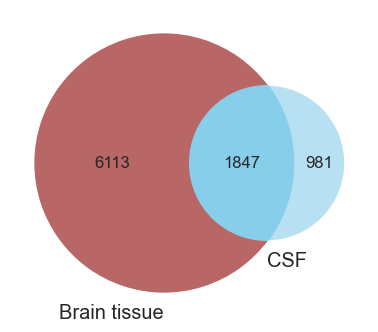

In [19]:
sns.set(style=("ticks"), font_scale=1)
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# entire dataset
v = venn2([set(Higginbotham2020_brain["Uniprot"]), set(Higginbotham2020_CSF["Uniprot"])], ["Brain tissue", "CSF"], 
    set_colors=("darkred", "skyblue"))
v.get_patch_by_id("11").set_color("skyblue")
v.get_patch_by_id("10").set_alpha(0.6)
v.get_patch_by_id("11").set_alpha(1.0)
v.get_patch_by_id("01").set_alpha(0.6)

plt.show()
fig.savefig(fig_path + "Venn_brain_tissue_CSF_Higginbotham.png", bbox_inches="tight")

In [20]:
brain_tissue = set(Higginbotham2020_brain["Uniprot"])
only_brain = set(Higginbotham2020_brain["Uniprot"]) - set(Higginbotham2020_CSF["Uniprot"])
brain_to_CSF = set(Higginbotham2020_brain["Uniprot"]).intersection(set(Higginbotham2020_CSF["Uniprot"]))
print("Proteins found in brain tissue:", len(brain_tissue))
print("Proteins only found in brain tissue:", len(only_brain))
print("Proteins found in brain and CSF tissue:", len(brain_to_CSF))

Proteins found in brain tissue: 7960
Proteins only found in brain tissue: 6113
Proteins found in brain and CSF tissue: 1847


In [21]:
brain_tissue_proba = df_pred[df_pred["Uniprot"].isin(brain_tissue)]
only_brain_proba = df_pred[df_pred["Uniprot"].isin(only_brain)]
brain_to_CSF_proba = df_pred[df_pred["Uniprot"].isin(brain_to_CSF)]
print("Proteins found in brain tissue in our data set:", len(brain_tissue_proba))
print("Proteins only found in brain tissue in our data set:", len(only_brain_proba))
print("Proteins found in brain and CSF tissue in our data set:", len(brain_to_CSF_proba))

Proteins found in brain tissue in our data set: 7605
Proteins only found in brain tissue in our data set: 5824
Proteins found in brain and CSF tissue in our data set: 1781


In [22]:
# venn2([set(csf["Uniprot"]), set(brain_to_CSF)], ["CSF proteome", "Higginbotham Brain to CSF"])
# plt.show()

In [23]:
#### TO DO ####
# check if these 301 are brain derived (part of the HPA set)?

additional_brain_to_csf_proteins = set(brain_to_CSF) - set(csf["Uniprot"])
len(additional_brain_to_csf_proteins)

301

In [24]:
a = df_pred[df_pred["Uniprot"].isin(additional_brain_to_csf_proteins)]
print(len(a))
print(len(a[a["CSF_proba"] > 0.5])/len(a))
print(len(a[a["CSF_proba_2plus"] > 0.5])/len(a))
print(len(a[a["CSF_proba_3plus"] > 0.5])/len(a))

251
0.6613545816733067
0.5657370517928287
0.549800796812749


In [25]:
# how well does the model do on positive proteins that are part of the training set?
x = brain_to_CSF_proba[brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("CSF proteins:", len(x[x["CSF_proba"] > 0.5])/len(x))
x = only_brain_proba[only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("Non-CSF proteins:", len(x[x["CSF_proba"] < 0.5])/len(x))

#### TO DO ####
# these are not the correct datasets (since 2+ and 3+ have been trained on a smaller set than brain elevated)

x = brain_to_CSF_proba[brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("CSF proteins:", len(x[x["CSF_proba_2plus"] > 0.5])/len(x))
x = only_brain_proba[only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("Non-CSF proteins:", len(x[x["CSF_proba_2plus"] < 0.5])/len(x))

# how well does the model do on positive proteins that are part of the training set?
x = brain_to_CSF_proba[brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("CSF proteins:", len(x[x["CSF_proba_3plus"] > 0.5])/len(x))
x = only_brain_proba[only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])] 
print("Non-CSF proteins:", len(x[x["CSF_proba_3plus"] < 0.5])/len(x))

CSF proteins: 0.8592233009708737
Non-CSF proteins: 0.532394366197183
CSF proteins: 0.7815533980582524
Non-CSF proteins: 0.6704225352112676
CSF proteins: 0.75
Non-CSF proteins: 0.7647887323943662


In [26]:
# how well does the model do on positive proteins that are not part of the training set?
y = brain_to_CSF_proba[-brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("CSF proteins:", len(y[y["CSF_proba"] > 0.5])/len(y))
y = only_brain_proba[-only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("Non-CSF proteins:", len(y[y["CSF_proba"] < 0.5])/len(y))

#### TO DO ####
# these are not the correct datasets (since 2+ and 3+ have been trained on a smaller set than brain elevated)

y = brain_to_CSF_proba[-brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("CSF proteins:", len(y[y["CSF_proba_2plus"] > 0.5])/len(y))
y = only_brain_proba[-only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("Non-CSF proteins:", len(y[y["CSF_proba_2plus"] < 0.5])/len(y))

y = brain_to_CSF_proba[-brain_to_CSF_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("CSF proteins:", len(y[y["CSF_proba_3plus"] > 0.5])/len(y))
y = only_brain_proba[-only_brain_proba["Uniprot"].isin(df_elevated["Uniprot"])]
print("Non-CSF proteins:", len(y[y["CSF_proba_3plus"] < 0.5])/len(y))

CSF proteins: 0.7699050401753105
Non-CSF proteins: 0.6169339069221744
CSF proteins: 0.6676406135865596
Non-CSF proteins: 0.7373875635510364
CSF proteins: 0.6574141709276844
Non-CSF proteins: 0.7743449354712554


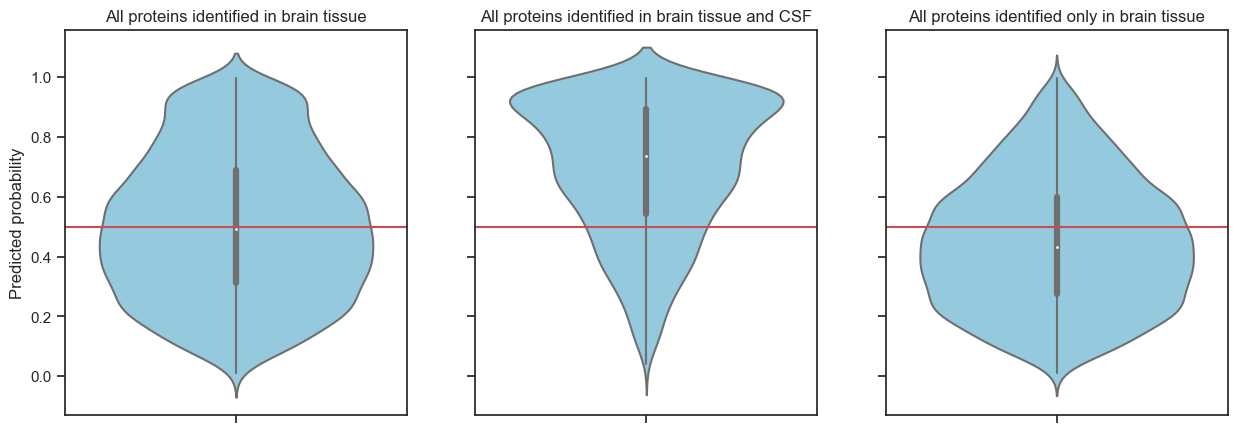

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
sns.violinplot(y="CSF_proba", data=brain_tissue_proba, orient="v", palette=["skyblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All proteins identified in brain tissue")
ax[0].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba", data=brain_to_CSF_proba, orient="v", palette=["skyblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="All proteins identified in brain tissue and CSF")
ax[1].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba", data=only_brain_proba, orient="v", palette=["skyblue"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="All proteins identified only in brain tissue")
ax[2].axhline(y=0.5, color="r", linestyle="-")

plt.show()
fig.savefig(fig_path + "Violin_probability_brain_tissue_CSF_Higginbotham.png", bbox_inches="tight")

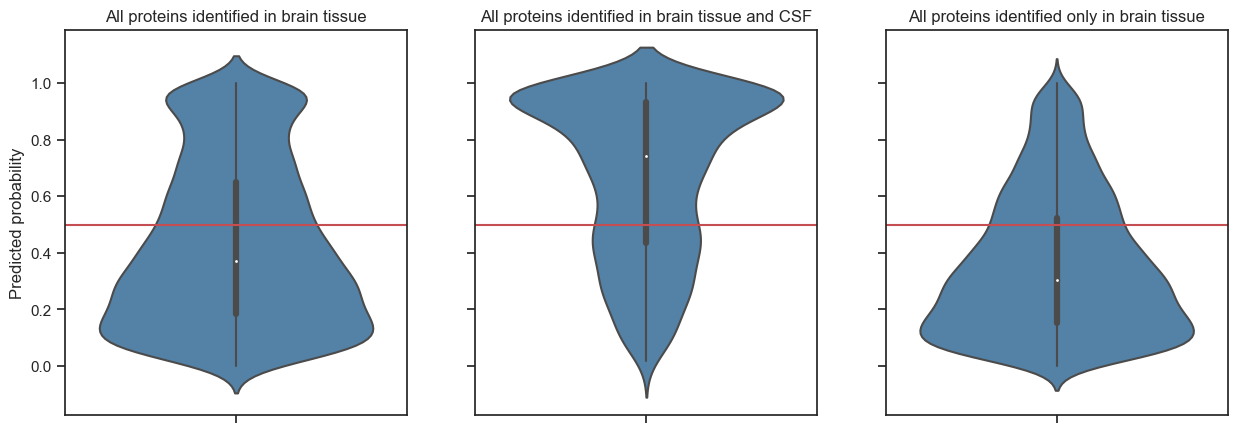

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
sns.violinplot(y="CSF_proba_2plus", data=brain_tissue_proba, orient="v", palette=["steelblue"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All proteins identified in brain tissue")
ax[0].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba_2plus", data=brain_to_CSF_proba, orient="v", palette=["steelblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="All proteins identified in brain tissue and CSF")
ax[1].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba_2plus", data=only_brain_proba, orient="v", palette=["steelblue"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="All proteins identified only in brain tissue")
ax[2].axhline(y=0.5, color="r", linestyle="-")

plt.show()
fig.savefig(fig_path + "Violin_probability_brain_tissue_CSF_Higginbotham_2plus.png", bbox_inches="tight")

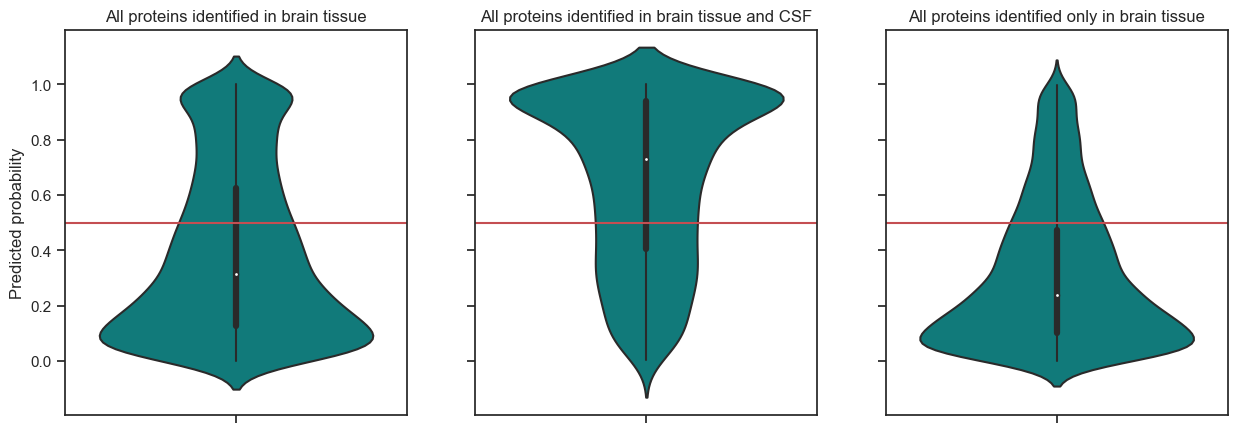

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
sns.violinplot(y="CSF_proba_3plus", data=brain_tissue_proba, orient="v", palette=["darkcyan"], ax=ax[0])
ax[0].set(xlabel=None, ylabel="Predicted probability", title="All proteins identified in brain tissue")
ax[0].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba_3plus", data=brain_to_CSF_proba, orient="v", palette=["darkcyan"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="All proteins identified in brain tissue and CSF")
ax[1].axhline(y=0.5, color="r", linestyle="-")
sns.violinplot(y="CSF_proba_3plus", data=only_brain_proba, orient="v", palette=["darkcyan"], ax=ax[2])
ax[2].set(xlabel=None, ylabel=None, title="All proteins identified only in brain tissue")
ax[2].axhline(y=0.5, color="r", linestyle="-")

plt.show()
fig.savefig(fig_path + "Violin_probability_brain_tissue_CSF_Higginbotham_3plus.png", bbox_inches="tight")

In [30]:
print("Entire CSF proteome")
print("Median predicted probability for all brain tissue proteins:", round(np.median(brain_tissue_proba["CSF_proba"]), 4))
print("Median predicted probability for brain tissue to CSF proteins:", round(np.median(brain_to_CSF_proba["CSF_proba"]), 4))
print("Median predicted probability for only brain tissue proteins:", round(np.median(only_brain_proba["CSF_proba"]), 4))

print("2+ studies CSF proteome")
print("Median predicted probability for all brain tissue proteins:", round(np.median(brain_tissue_proba["CSF_proba_2plus"]), 4))
print("Median predicted probability for brain tissue to CSF proteins:", round(np.median(brain_to_CSF_proba["CSF_proba_2plus"]), 4))
print("Median predicted probability for only brain tissue proteins:", round(np.median(only_brain_proba["CSF_proba_2plus"]), 4))

print("3+ studies  CSF proteome")
print("Median predicted probability for all brain tissue proteins:", round(np.median(brain_tissue_proba["CSF_proba_3plus"]), 4))
print("Median predicted probability for brain tissue to CSF proteins:", round(np.median(brain_to_CSF_proba["CSF_proba_3plus"]), 4))
print("Median predicted probability for only brain tissue proteins:", round(np.median(only_brain_proba["CSF_proba_3plus"]), 4))

Entire CSF proteome
Median predicted probability for all brain tissue proteins: 0.4909
Median predicted probability for brain tissue to CSF proteins: 0.7371
Median predicted probability for only brain tissue proteins: 0.4334
2+ studies CSF proteome
Median predicted probability for all brain tissue proteins: 0.3727
Median predicted probability for brain tissue to CSF proteins: 0.7409
Median predicted probability for only brain tissue proteins: 0.3055
3+ studies  CSF proteome
Median predicted probability for all brain tissue proteins: 0.3138
Median predicted probability for brain tissue to CSF proteins: 0.7315
Median predicted probability for only brain tissue proteins: 0.2376


Entire CSF proteome
Median predicted probability for all brain tissue proteins: 0.4918
Median predicted probability for brain tissue to CSF proteins: 0.7366
Median predicted probability for only brain tissue proteins: 0.4338
2+ studies CSF proteome
Median predicted probability for all brain tissue proteins: 0.373
Median predicted probability for brain tissue to CSF proteins: 0.7381
Median predicted probability for only brain tissue proteins: 0.305
3+ studies  CSF proteome
Median predicted probability for all brain tissue proteins: 0.3149
Median predicted probability for brain tissue to CSF proteins: 0.734
Median predicted probability for only brain tissue proteins: 0.2373

In [31]:
print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba"] > 0.5).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba"] > 0.5).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba"] > 0.5).sum()/len(only_brain_proba), 4))

print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba_2plus"] > 0.5).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba_2plus"] > 0.5).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba_2plus"] > 0.5).sum()/len(only_brain_proba), 4))

print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba_3plus"] > 0.5).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba_3plus"] > 0.5).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba_3plus"] > 0.5).sum()/len(only_brain_proba), 4))

Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.4864
	in brain tissue to CSF proteins: 0.7906
	in only brain tissue proteins: 0.3934
Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.3699
	in brain tissue to CSF proteins: 0.694
	in only brain tissue proteins: 0.2708
Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.3327
	in brain tissue to CSF proteins: 0.6788
	in only brain tissue proteins: 0.2268


In [32]:
print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba"] > 0.8).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba"] > 0.8).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba"] > 0.8).sum()/len(only_brain_proba), 4))

print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba_2plus"] > 0.8).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba_2plus"] > 0.8).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba_2plus"] > 0.8).sum()/len(only_brain_proba), 4))

print("Fraction of protein predicted to be CSF secreted...")
print("\tin all brain tissue proteins:", round((brain_tissue_proba["CSF_proba_3plus"] > 0.8).sum()/len(brain_tissue_proba), 4))
print("\tin brain tissue to CSF proteins:", round((brain_to_CSF_proba["CSF_proba_3plus"] > 0.8).sum()/len(brain_to_CSF_proba), 4))
print("\tin only brain tissue proteins:", round((only_brain_proba["CSF_proba_3plus"] > 0.8).sum()/len(only_brain_proba), 4))

Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.1448
	in brain tissue to CSF proteins: 0.4076
	in only brain tissue proteins: 0.0644
Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.1565
	in brain tissue to CSF proteins: 0.4436
	in only brain tissue proteins: 0.0687
Fraction of protein predicted to be CSF secreted...
	in all brain tissue proteins: 0.1538
	in brain tissue to CSF proteins: 0.4323
	in only brain tissue proteins: 0.0687


In [33]:
# is brain expression lower in false positives compared to true positives?
FP_hi = only_brain_proba[only_brain_proba["CSF_proba"] > 0.5]
print("Number of false positives:", len(FP_hi))
TP_hi = brain_to_CSF_proba[brain_to_CSF_proba["CSF_proba"] > 0.5]
print("Number of true positives:", len(TP_hi))
FN_hi = brain_to_CSF_proba[brain_to_CSF_proba["CSF_proba"] < 0.5]
print("Number of false negatives:", len(FN_hi))
TN_hi = only_brain_proba[only_brain_proba["CSF_proba"] < 0.5]
print("Number of true negatives:", len(TN_hi))

Number of false positives: 2291
Number of true positives: 1408
Number of false negatives: 373
Number of true negatives: 3533


In [34]:
A = set(brain_to_CSF_proba["Uniprot"]).intersection(set(brain_tissue_proba[brain_tissue_proba["CSF_proba"] > 0.5]["Uniprot"]))
B = set(brain_to_CSF_proba["Uniprot"]).intersection(set(brain_tissue_proba[brain_tissue_proba["CSF_proba"] < 0.5]["Uniprot"]))

print("Fraction of protein secreted to CSF...")
print("\tin proteins predicted to be in CSF:", 
    round(len(A)/len(brain_tissue_proba[brain_tissue_proba["CSF_proba"] > 0.5]), 4)) # 1271/(1271+1881)
print("\tin proteins predicted not to be in CSF:", 
    round(len(B)/len(brain_tissue_proba[brain_tissue_proba["CSF_proba"] < 0.5]), 4)) # 316/(316+3045)

Fraction of protein secreted to CSF...
	in proteins predicted to be in CSF: 0.3806
	in proteins predicted not to be in CSF: 0.0955


In [35]:
_, p = mannwhitneyu(brain_tissue_proba["CSF_proba"], brain_to_CSF_proba["CSF_proba"])
print("p-value:", p)

p-value: 2.2763078971250566e-183


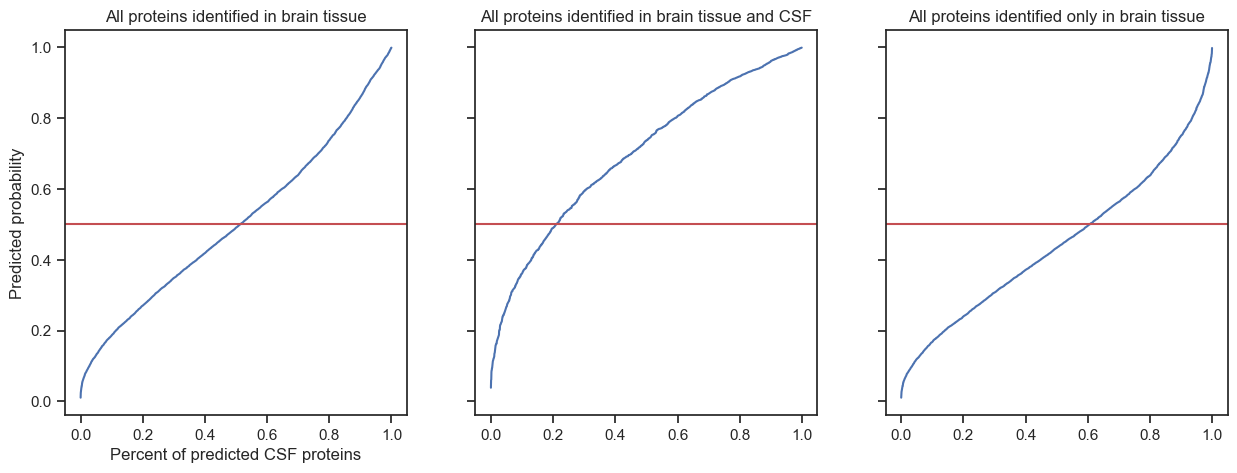

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)

ax[0].plot([len(brain_tissue_proba[brain_tissue_proba["CSF_proba"] < i])/len(brain_tissue_proba) for i in 
    brain_tissue_proba["CSF_proba"]], brain_tissue_proba["CSF_proba"])
ax[0].set(xlabel="Percent of predicted CSF proteins", ylabel="Predicted probability", title="All proteins identified in brain tissue")
ax[0].axhline(y=0.5, color="r", linestyle="-")
ax[1].plot([len(brain_to_CSF_proba[brain_to_CSF_proba["CSF_proba"] < i])/len(brain_to_CSF_proba) for i in 
    brain_to_CSF_proba["CSF_proba"]], brain_to_CSF_proba["CSF_proba"])
ax[1].set(xlabel=None, ylabel=None, title="All proteins identified in brain tissue and CSF")
ax[1].axhline(y=0.5, color="r", linestyle="-")
ax[2].plot([len(only_brain_proba[only_brain_proba["CSF_proba"] < i])/len(only_brain_proba) for i in 
    only_brain_proba["CSF_proba"]], only_brain_proba["CSF_proba"])
ax[2].set(xlabel=None, ylabel=None, title="All proteins identified only in brain tissue")
ax[2].axhline(y=0.5, color="r", linestyle="-")

plt.show()
fig.savefig(fig_path + "Probability_fraction_predicted_CSF_Higginbotham.png", bbox_inches="tight")

In [37]:
brain_exp = brain_elevated[["Uniprot", "Brain expression"]]
brain_exp["log2(Brain expression)"] = np.log2(brain_exp["Brain expression"])
brain_exp_CSF = brain_exp.merge(df_pred[["Uniprot", "CSF", "CSF_proba"]], on="Uniprot", how="inner")
brain_exp_CSF["CSF_proba_binary"] = np.where(brain_exp_CSF["CSF_proba"] > 0.5, 1, -1)

In [38]:
# overlap with expression data
brain_exp_FP_hi = brain_exp.merge(FP_hi[["Uniprot", "CSF_proba"]], on="Uniprot", how="inner")
brain_exp_FP_hi["CSF_proba_binary"] = np.where(brain_exp_FP_hi["CSF_proba"] > 0.5, 1, -1)
brain_exp_TP_hi = brain_exp.merge(TP_hi[["Uniprot", "CSF_proba"]], on="Uniprot", how="inner")
brain_exp_TP_hi["CSF_proba_binary"] = np.where(brain_exp_TP_hi["CSF_proba"] > 0.5, 1, -1)

6.461630120855052
5.5682212292917335


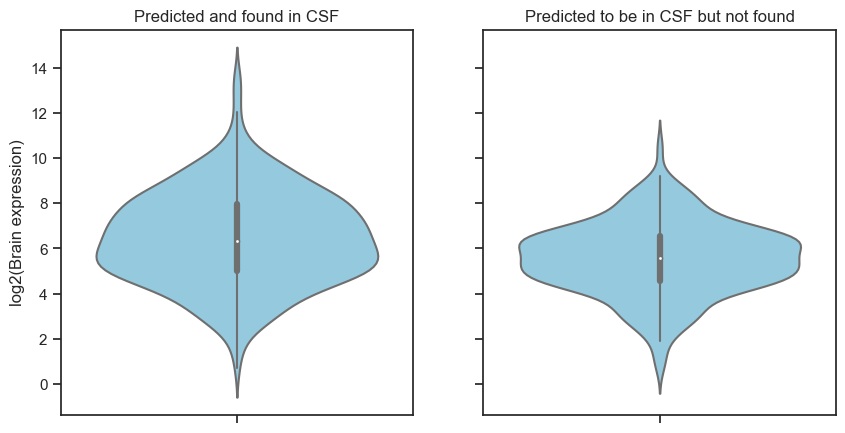

In [39]:
print(np.mean(brain_exp_TP_hi["log2(Brain expression)"]))
print(np.mean(brain_exp_FP_hi["log2(Brain expression)"]))

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

sns.violinplot(y="log2(Brain expression)", data=brain_exp_TP_hi, orient="v", palette=["skyblue"], ax=ax[0])
ax[0].set(xlabel=None, title="Predicted and found in CSF")
sns.violinplot(y="log2(Brain expression)", data=brain_exp_FP_hi, orient="v", palette=["skyblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="Predicted to be in CSF but not found")

plt.show()
fig.savefig(fig_path + "Violin_true_and_false_positives_brain_expression_Higginbotham.png", bbox_inches="tight")

In [40]:
annotation_score = pd.read_csv(data_path + "/Uniprot/Uniprot_human_proteome_annotation_score.tsv", sep="\t", header=0,
    names=["Uniprot", "Annotation"])
annotation_score["log2(Annotation)"] = np.log2(annotation_score["Annotation"])

protein_existence = pd.read_csv(data_path + "/Uniprot/Uniprot_human_proteome_protein_existence.tsv", sep="\t", header=0,
    names=["Uniprot", "Protein existence"])

In [41]:
annotation_score_FP_hi = annotation_score.merge(FP_hi[["Uniprot", "CSF_proba"]], on="Uniprot", how="inner")
annotation_score_TP_hi = annotation_score.merge(TP_hi[["Uniprot", "CSF_proba"]], on="Uniprot", how="inner")

protein_existence_FP_hi = protein_existence.merge(FP_hi[["Uniprot", "CSF_proba"]], on="Uniprot", how="inner")
protein_existence_TP_hi = protein_existence.merge(TP_hi[["Uniprot", "CSF_proba"]], on="Uniprot", how="inner")

7.533767623632933
7.317389131567573


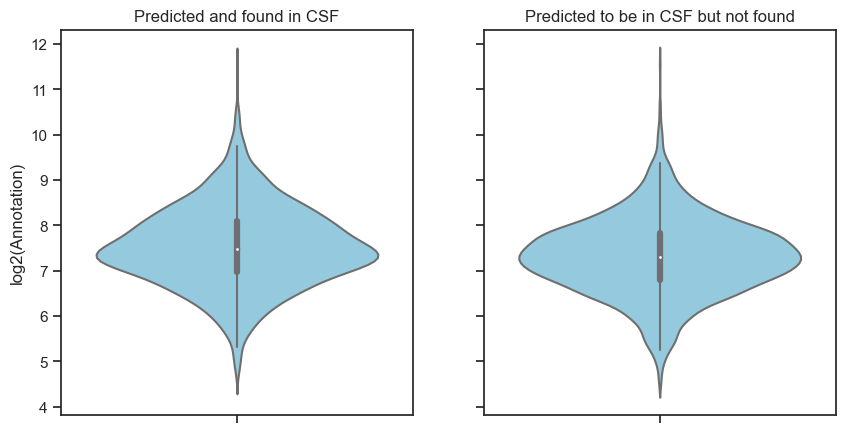

In [42]:
print(np.mean(annotation_score_TP_hi["log2(Annotation)"]))
print(np.mean(annotation_score_FP_hi["log2(Annotation)"]))

fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

sns.violinplot(y="log2(Annotation)", data=annotation_score_TP_hi, orient="v", palette=["skyblue"], ax=ax[0])
ax[0].set(xlabel=None, title="Predicted and found in CSF")
sns.violinplot(y="log2(Annotation)", data=annotation_score_FP_hi, orient="v", palette=["skyblue"], ax=ax[1])
ax[1].set(xlabel=None, ylabel=None, title="Predicted to be in CSF but not found")

plt.show()

In [43]:
protein_existence_TP_hi["Protein existence"].value_counts(normalize=True)

Evidence at protein level       0.956857
Evidence at transcript level    0.038521
Inferred from homology          0.003082
Uncertain                       0.000770
Predicted                       0.000770
Name: Protein existence, dtype: float64

In [44]:
protein_existence_FP_hi["Protein existence"].value_counts(normalize=True)

Evidence at protein level       0.961656
Evidence at transcript level    0.030164
Uncertain                       0.004090
Inferred from homology          0.004090
Name: Protein existence, dtype: float64